Total frames: 322
Usable right heel frames: 322
Found minimum at frame 4: Y=0.752
Found minimum at frame 80: Y=0.747
Found minimum at frame 157: Y=0.753
Found minimum at frame 234: Y=0.769
Found minimum at frame 307: Y=0.774

Found 5 Local Minima:
Minimum 1: Frame 4, Time 0.133s, Y = 0.75170
Minimum 2: Frame 80, Time 2.667s, Y = 0.74691
Minimum 3: Frame 157, Time 5.233s, Y = 0.75274
Minimum 4: Frame 234, Time 7.800s, Y = 0.76938
Minimum 5: Frame 307, Time 10.233s, Y = 0.77436

Ground truth right foot steps: 4
GT: Frame 22, Time 0.733s, Y = 0.83893
GT: Frame 100, Time 3.333s, Y = 0.84336
GT: Frame 178, Time 5.933s, Y = 0.86123
GT: Frame 255, Time 8.500s, Y = 0.88737

Detected step intervals:
  Interval 1: 2.533s
  Interval 2: 2.567s
  Interval 3: 2.567s
  Interval 4: 2.433s

Timing statistics:
  Average interval: 2.525s
  Std deviation: 0.055s


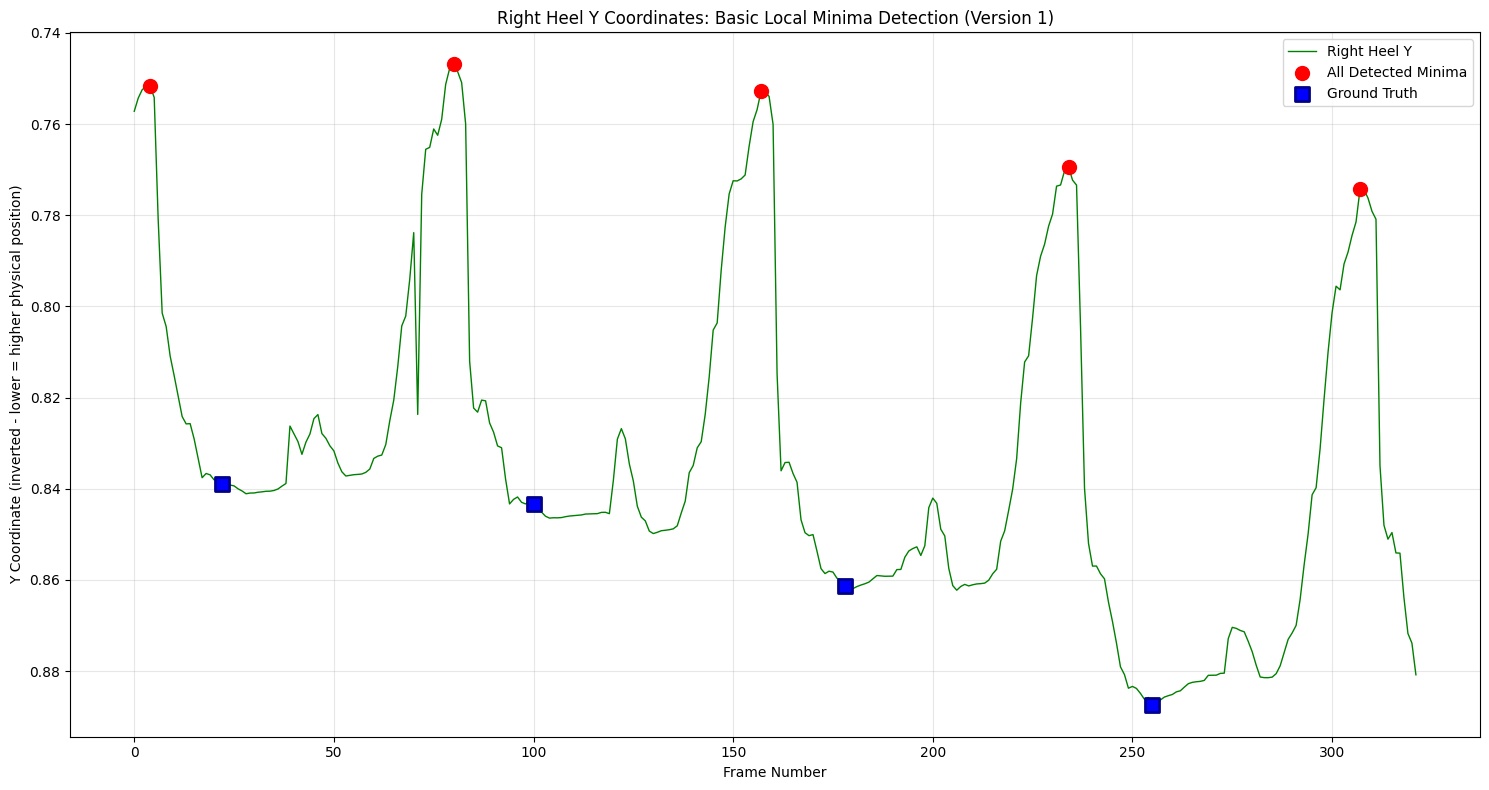


COMPARISON:
Ground truth right steps: 4
Detected minima: 5
Detection ratio: 1.25


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# Load the CSV from your heel detector
df = pd.read_csv('/Users/yejinbang/Documents/GitHub/sfx-project/data/walk4_frame_data_v1.csv')

# Load ground truth data
with open('/Users/yejinbang/Documents/GitHub/sfx-project/data/test_videos/walk4_ground_truth.json', 'r') as f:
    gt_data = json.load(f)

# Filter out frames where right heel is not usable (low confidence)
df_filtered = df[df['right_heel_usable'] == True].copy()

print(f"Total frames: {len(df)}")
print(f"Usable right heel frames: {len(df_filtered)}")

def find_local_minima_basic(df_data, window_size=3, min_distance=10):
    """
    Version 1: Basic local minima detection - shows all minima for RIGHT foot
    """
    minima = []
    y_values = df_data['right_heel_y'].values  # CHANGED: left_heel_y → right_heel_y
    frames = df_data['frame_number'].values
    timestamps = df_data['timestamp'].values
    
    n = len(y_values)
    
    for i in range(window_size, n - window_size):
        current_val = y_values[i]
        
        # Check if it's a local minimum
        is_minimum = True
        for j in range(i - window_size, i + window_size + 1):
            if j != i and y_values[j] <= current_val:
                is_minimum = False
                break
        
        if is_minimum:
            # Apply minimum distance constraint only
            if not minima or (i - minima[-1]['index']) >= min_distance:
                minima.append({
                    'index': i,
                    'frame_number': frames[i],
                    'timestamp': timestamps[i],
                    'y_value': current_val
                })
                print(f"Found minimum at frame {frames[i]}: Y={current_val:.3f}")
    
    return minima

# Find local minima using basic approach
minima = find_local_minima_basic(df_filtered, window_size=3, min_distance=60)

print(f"\nFound {len(minima)} Local Minima:")
for i, minimum in enumerate(minima):
    print(f"Minimum {i+1}: Frame {minimum['frame_number']}, "
          f"Time {minimum['timestamp']:.3f}s, Y = {minimum['y_value']:.5f}")

# Extract ground truth RIGHT foot steps  
gt_right_steps = [step for step in gt_data['annotations'] if step['foot'] == 'right']  # CHANGED: left → right
print(f"\nGround truth right foot steps: {len(gt_right_steps)}")

# Get Y coordinates for ground truth frames
gt_frames = []
gt_y_values = []
for gt_step in gt_right_steps:
    frame_num = gt_step['frame']
    matching_row = df_filtered[df_filtered['frame_number'] == frame_num]
    if not matching_row.empty:
        gt_frames.append(frame_num)
        gt_y_values.append(matching_row['right_heel_y'].iloc[0])  # CHANGED: left_heel_y → right_heel_y
        print(f"GT: Frame {frame_num}, Time {gt_step['timestamp']:.3f}s, Y = {matching_row['right_heel_y'].iloc[0]:.5f}")

# Calculate intervals between steps
if len(minima) > 1:
    intervals = []
    for i in range(1, len(minima)):
        interval = minima[i]['timestamp'] - minima[i-1]['timestamp']
        intervals.append(interval)
    
    print(f"\nDetected step intervals:")
    for i, interval in enumerate(intervals):
        print(f"  Interval {i+1}: {interval:.3f}s")
    
    print(f"\nTiming statistics:")
    print(f"  Average interval: {np.mean(intervals):.3f}s")
    print(f"  Std deviation: {np.std(intervals):.3f}s")

# Visualize results
plt.figure(figsize=(15, 8))
plt.plot(df_filtered['frame_number'], df_filtered['right_heel_y'], 'g-', linewidth=1, label='Right Heel Y')  # CHANGED: blue → green, left → right

# Mark detected minima (RED dots)
if minima:
    min_frames = [m['frame_number'] for m in minima]
    min_y_vals = [m['y_value'] for m in minima]
    plt.scatter(min_frames, min_y_vals, color='red', s=100, zorder=5, label='All Detected Minima')

# Mark ground truth (BLUE squares)
if gt_frames:
    plt.scatter(gt_frames, gt_y_values, color='blue', s=100, marker='s', zorder=6, 
               label='Ground Truth', edgecolors='darkblue', linewidth=2)

plt.xlabel('Frame Number')
plt.ylabel('Y Coordinate (inverted - lower = higher physical position)')
plt.title('Right Heel Y Coordinates: Basic Local Minima Detection (Version 1)')  # CHANGED: Left → Right
plt.grid(True, alpha=0.3)
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Compare detection accuracy
print(f"\n{'='*50}")
print("COMPARISON:")
print(f"Ground truth right steps: {len(gt_right_steps)}")  # CHANGED: left → right
print(f"Detected minima: {len(minima)}")
print(f"Detection ratio: {len(minima)/len(gt_right_steps):.2f}" if gt_right_steps else "N/A")